In [1]:
# Import all required libraries 

from ultralytics import YOLO
import numpy as np
from PIL import Image
import cv2
import colorsys
import random
import pandas as pd
import os

C:\Users\SAQIBQ\Anaconda3\envs\Segment-anything\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load a custom YOLO model using the "best.pt" weights file
model = YOLO("best.pt") 

# Define the path to the input image
original_img = "131.jpg"

# Extract the base name of the input image file without the extension
image_base_name = os.path.splitext(os.path.basename(original_img))[0]

# Read the input image using OpenCV
original_img = cv2.imread(original_img)

# Get the height, width, and number of color channels of the input image
height, width, channels = original_img.shape

# Initialize a variable to store the desired image size (imgsz)
imgsz = None

# Determine the desired image size based on the width of the input image
if 500 < width < 2500:
    imgsz = 1024
elif 2500 < width < 5000:
    imgsz = 3000
elif 5000 < width < 9000:
    imgsz = 6000
    
# If the image size could not be determined within the specified ranges, set it to 2048
if imgsz is None:
    imgsz = 512 
#print("imgsz:", imgsz)

In [4]:
# Use the YOLO model to detect objects in the input image
def detect(model, img):
    # Perform instance segmentation and store the results in the "results" variable
    results = model.predict(source=img.copy(), project="Result", name="pred", imgsz=imgsz, save=True, iou=0.8, conf=0.6, save_txt=False)
    result = results[0]
    # Initialize lists to store segment information and total contour areas
    segments = []
    total_area= []
    # Get the shape of the original image from the result
    h2, w2, c2 = results[0].orig_img.shape
    # Process each mask in the result
    for x in result.masks.cpu().data.numpy().astype('uint8'):
        # Resize the mask to match the shape of the original image
        x = cv2.resize(x, (w2, h2))
        # Find contours in the mask
        c = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        # Calculate the total area of contours in the mask
        contour_area = 0
        for contour in c:
            area = cv2.contourArea(contour)
            contour_area += area
        # Concatenate the contours and add them to the segments list
        c = np.concatenate([x.reshape(-1, 2) for x in c])
        # Concatenate the contours and add them to the segments list
        segments.append(c.astype('float32'))
        total_area.append(contour_area)
        
    # Extract bounding boxes, class IDs, and scores from the result
    bboxes = np.array(result.boxes.xyxy.cpu(), dtype="int")
    class_ids = np.array(result.boxes.cls.cpu(), dtype="int")
    scores = np.array(result.boxes.conf.cpu(), dtype="float").round(2)
    
    # Return the detected bounding boxes, class IDs, segments, scores, and total contour areas
    return bboxes, class_ids, segments, scores, total_area

In [5]:
   """
    Draw a mask on an image using specified points and color with optional transparency.

    Parameters:
    - img: The input image on which the mask will be drawn.
    - pts: List of points that define the mask shape.
    - color: The RGB color to fill the mask with.
    - alpha: The transparency of the mask (0.0 for fully transparent, 1.0 for fully opaque).

    Returns:
    - The image with the mask drawn on it.

    This function takes an input image, a list of points (`pts`) that define the shape of the mask,
    a color in RGB format, and an optional transparency level (`alpha`). It then draws the mask on
    a copy of the input image and returns the resulting image.

    The `pts` parameter should be a list of points, each represented as a tuple (x, y), where x and y
    are the coordinates in the image. The `color` parameter specifies the fill color of the mask, and
    `alpha` controls the transparency of the mask, allowing the underlying image to show through.
    """
def draw_mask(img, pts, color, alpha=0.5):
    h, w, _ = img.shape

    overlay = img.copy()
    output = img.copy()

    pts_list = [np.array(pts, dtype=np.int32)]  # Convert the input `pts` to the correct format
    cv2.fillPoly(overlay, pts_list, color)
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    return output

In [6]:
   """
    Generate random colors for visual distinction.

    Parameters:
    - N: Number of colors to generate.
    - bright: If True, generate bright and vivid colors; otherwise, generate more muted colors.

    Returns:
    - A list of RGB colors in the form (R, G, B).

    This function generates random colors in HSV color space and then converts them to RGB
    to create a visually distinct set of colors. The `N` parameter specifies the number of colors
    to generate, and `bright` controls whether the colors are bright or more muted. The function
    returns a list of RGB colors that can be used for various purposes, such as visualizing
    distinct objects in an image.
    """
def random_colors(N, bright=True):
    brightness = 255 if bright else 180
    hsv = [(i / N + 1, 1, brightness) for i in range(N + 1)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors 

In [7]:
#class_names = ['Fibre', 'Vessel']  # We have two class in custom dataset.
# We set the two different colors for each class. We can set the different color to each object, just replace "len(class_names)" to "len(classes)". See in the below cell
#colors = random_colors(len(class_names)) 
#list2=[]
#img = original_img.copy()

In [8]:
class_names = ['Fibre', 'Vessel']  # We have two class in custom dataset.
img = original_img.copy() # Create a copy of the original image to work on

bboxes, classes, segmentations, scores, area = detect(model, img)
colors = random_colors(len(bboxes))
list2=[]
for i, (bbox, class_id, seg, score, area) in enumerate(zip(bboxes, classes, segmentations, scores, area)):
    color = colors[i]
    # Extract information for each detected object
    # print("bbox:", bbox, "class id:", class_id, "seg:", seg, "score:", score)
    (x, y, x2, y2) = bbox       # Unpack bounding box coordinates and segmentation points
    rect = cv2.minAreaRect(seg)  # Calculate the minimum area rectangle (rotated rectangle) that encloses the segmentation. 
    box1 = cv2.boxPoints(rect)  # Get the four corners of the rotated rectangle
    box1 = np.int0(box1)
    #print(box1)
    # Calculate the lengths of two sides of the rotated rectangle
    a,b,c,d=box1
    dst1= ((a[0] - b[0])**2 + (a[1] - b[1])**2)**0.5
    dst2 = ((b[0] - c[0])**2 + (b[1] - c[1])**2)**0.5
    
    # Choose the longer side as the length. conversion scale also applied here  (1 px = 0.65 mm)
    dst1 = dst1 * 0.65
    dst2 = dst2 * 0.65
    if dst1 > dst2:
      Length = dst1
    else:
      Length = dst2
    
    # Area and adjust via conversion scale in mm
    area_px = area * 0.65
    # Average Width is calculated
    Width = round(area_px/Length, 2)
    
    # Store all these information into the list to generate excel sheet.
    list1 = class_names[class_id], Length, Width, area_px
    list2.append(list1)
    
    
    #cv2.drawContours(img, [seg], 0, (0, 255, 0), 2)
    #cv2.drawContours(img, [bbox], 0, (0, 0, 255), 2)
    #cv2.rectangle(img, (x, y), (x2, y2), colors[class_id], 2)
    
    
    # Draw the object mask on the image using the object's class color
    img = draw_mask(img, [seg], color)
    #cv2.rectangle(img, (a, b), (c, d), (255, 0, 0), 2)
    
    # Draw the rotated rectangle around the object
    cv2.drawContours(img,[box1],0, (255, 0, 255),2)
    cv2.putText(img, class_names[class_id], (a[0], a[1] + 30), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 0), 2) # displaying label using BBox
    


0: 768x1024 5 fibres, 1 vessel, 136.0ms
Speed: 9.0ms preprocess, 136.0ms inference, 43.0ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to Result\pred5


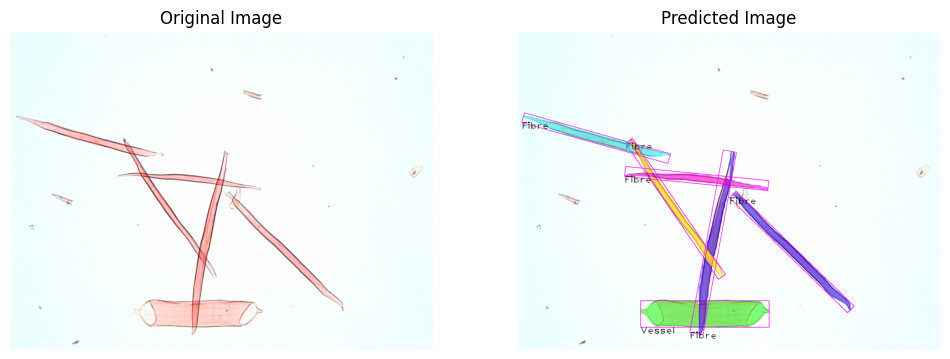

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # # Create a subplot with two columns for side-by-side display, specifying the figure size

# Display the original image on the left
axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the predicted image on the right
axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Predicted Image")
axes[1].axis('off')

plt.show()

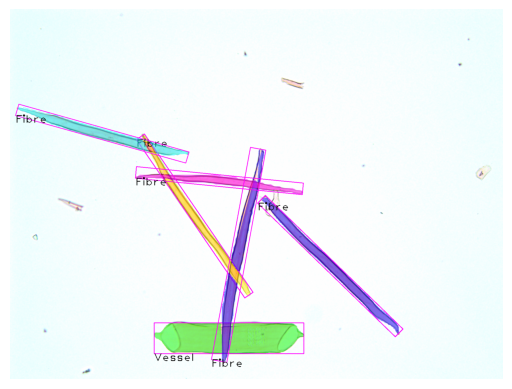

In [9]:
import matplotlib.pyplot as plt  # Import the matplotlib for displaying an image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Display the OpenCV image using matplotlib, converting it to RGB format
plt.axis('off')  # Turn off axis labels in the displayed image
plt.show()   # Show the image using plt.show()

In [34]:
list2

[('Fibre', 485.4138028527825, 30.89, 14995.5),
 ('Fibre', 485.71356013601263, 24.33, 11816.025),
 ('Vessel', 378.95, 95.27, 36101.975),
 ('Fibre', 447.58765901217606, 29.4, 13158.925000000001),
 ('Fibre', 545.9148743165, 31.07, 16963.375),
 ('Fibre', 424.5430602424211, 22.63, 9606.675000000001)]

In [10]:
df = pd.DataFrame(list2)   # Create a DataFrame from the 'list2' data
df1 = df.rename(columns={0: 'Class Name',1: 'Length', 2: 'Width', 3: 'Area'})    # Rename the columns for clarity
excel_file_name = image_base_name + "_summary.xlsx"     # Define the name of the Excel file to be generated
df1.to_excel(excel_file_name, index=False)  # Save the DataFrame as an Excel file

# Print a message to confirm the creation of the Excel file
print(f"Excel file '{excel_file_name}' has been created.")

Excel file '131_summary.xlsx' has been created.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

results = model.predict(source=img.copy(), project="D:/Clean_Dataset/Yolo8_result", name="saq", imgsz=1024, save=False, iou=0.6, conf=0.5, save_txt=False)

mask_raw = results[0].masks[5].cpu().data.numpy().astype('uint8')
mask_raw  = mask_raw .squeeze()  # This will remove the extra dimension (1)
mask_raw = (mask_raw  * 255).astype(np.uint8)

# Find contours in the binary mask
contours, _ = cv2.findContours(mask_raw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a variable to keep track of the total object area
total_area = 0

# Create a copy of the binary mask for visualization
mask_with_contours = mask_raw.copy()

# Calculate the area of each individual object and draw it on the visualization mask
for contour in contours:
    area = cv2.contourArea(contour)
    total_area += area
    # Draw the contour on the visualization mask
    cv2.drawContours(mask_with_contours, [contour], -1, (255), thickness=cv2.FILLED)

# Print the total object area
print("Total Object Area:", total_area)

# Visualize the mask with combined contours
plt.imshow(mask_with_contours, cmap='gray')
plt.title("Mask with Combined Contours")
plt.show()
